# Try HVAE layer

In [4]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Nicer way to import the module?
sys.path.append(str(Path.cwd().parent))

from utils.loading import load_net
from utils.data import make_generators_DF
from utils.train_val import validate_epoch
# from utils.evaluation import evaluate_adv_files_df, get_metrics

from utils.display import read_img_to_np, torch_to_np
from models.cvae import CVAE

import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms

import foolbox
import json
from PIL import Image

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())
print(torch.cuda.current_device())

PATH = Path('/media/rene/data/art/')
MODEL_PATH = PATH /'models' / 'cvae'

cuda:1
2
0


In [2]:
files_dict_loc = '/media/rene/data/art/files_dict.pkl'

with open(files_dict_loc, 'rb') as f:
    files_dict = pickle.load(f)

In [ ]:
from utils.data import make_generators_DF
from utils.loading import vae_from_args
from utils.train_val_auto import train_epoch_auto, validate_epoch_auto, save_checkpoint 



base_path = 
epochs, batch_size, lr, num_workers = 2, 4, .001, 1
IM_SIZE= 28

# SAVE_PATH = Path(args.SAVE_PATH)
# SAVE_PATH.mkdir(parents=True, exist_ok=True)


# Make generators:
dataloaders = make_generators_DF(files_dict=files_dict, base_path=base_path, batch_size=batch_size, IM_SIZE=IM_SIZE, 
                                 select_label=None, return_loc=False, path_colname='path', label_colname='label', num_workers=4)

# get the network
model, model_name = vae_from_args(args)
model = model.to(device)
print('next(model.parameters()).device', next(model.parameters()).device)
print(f'--------- Training: {model_name} ---------')

for p in model.parameters():
    p.requires_grad=True

# get training parameters and train:
optimizer = optim.Adam(model.parameters(), lr=lr)
print(model.parameters())
scheduler = lr_scheduler.StepLR(optimizer, step_size=int(epochs/2), gamma=0.2) # close enough

metrics = {}
metrics['train_losses'] = []
metrics['val_losses'] = []
#     best_val_loss = 100000000

criterion = model.loss

for epoch in tqdm(range(epochs)):
    # train for one epoch
    train_losses = train_epoch_auto(epoch, lr, dataloaders['train'], model, optimizer, criterion, device)
    metrics['train_losses'].append(train_losses)

    # evaluate on validation set
    val_losses = validate_epoch_auto(dataloaders['val'], model, criterion, device)
    metrics['val_losses'].append(val_losses)

    scheduler.step()

    # remember best validation accuracy and save checkpoint
    is_best = val_losses < best_val_loss
    best_val_loss = min(val_losses, best_val_loss)
    save_checkpoint({
        'model_name': model_name,
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict(),
        'epoch': epoch + 1,
        'best_val_loss': best_val_loss,
        'metrics': metrics,
    }, is_best, model_name, SAVE_PATH)

pickle.dump(metrics, open(str(SAVE_PATH)+'/'+str(model_name)+'_stride_'+str(args.stride)+'_metrics.pkl', "wb"))

In [5]:
def display_results_auto(vae_model, files_df, base_path, num_samples=5, data='cifar', size = 64, label_col_name='label'):
    with torch.cuda.device(1): # ??? Why the fuck???
        all_labels = files_df[label_col_name].unique()
        num_labels = len(all_labels)
        row_names = []
        col_names = ['Original', "Reconstructed"]

        fig, ax = plt.subplots(num_samples, 2, sharex='col', sharey='row',figsize=(15,15))

        for i, label in enumerate(all_labels[0:num_samples]):
            sample_df = files_df.loc[files_df[label_col_name] == label].sample(n=1)
            img_path = base_path /sample_df['path'].iloc[0]
            label = sample_df[label_col_name].iloc[0]
            row_names.append(label)

            if data == 'mnist': # MNIST
                img = read_img_to_np(img_path, bw=True)
                transform = transforms.Compose([
                                                transforms.Resize(size),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.1307,), (0.3081,))])
            elif data == 'cifar': # CIFAR10
                img = read_img_to_np(img_path, bw=False, size=size)
                transform = transforms.Compose([
                                                transforms.Resize(size),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.4914, 0.4822, 0.4465], 
                                                                     [0.2023, 0.1994, 0.2010])])

            tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)

            tensor_label = torch.from_numpy(np.array(label)).unsqueeze(0).type(torch.LongTensor).to(device)
            recon_x, mu, logvar = model(tensor_img, tensor_label)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(torch_to_np(recon_x))
            ax[i, 0].axis('off')
            ax[i, 1].axis('off')

        for curr_ax, col in zip(ax[0], col_names):
            curr_ax.set_title(col)

        for curr_ax, row in zip(ax[:,0], row_names):
            curr_ax.set_ylabel(row, rotation=0, size='large')

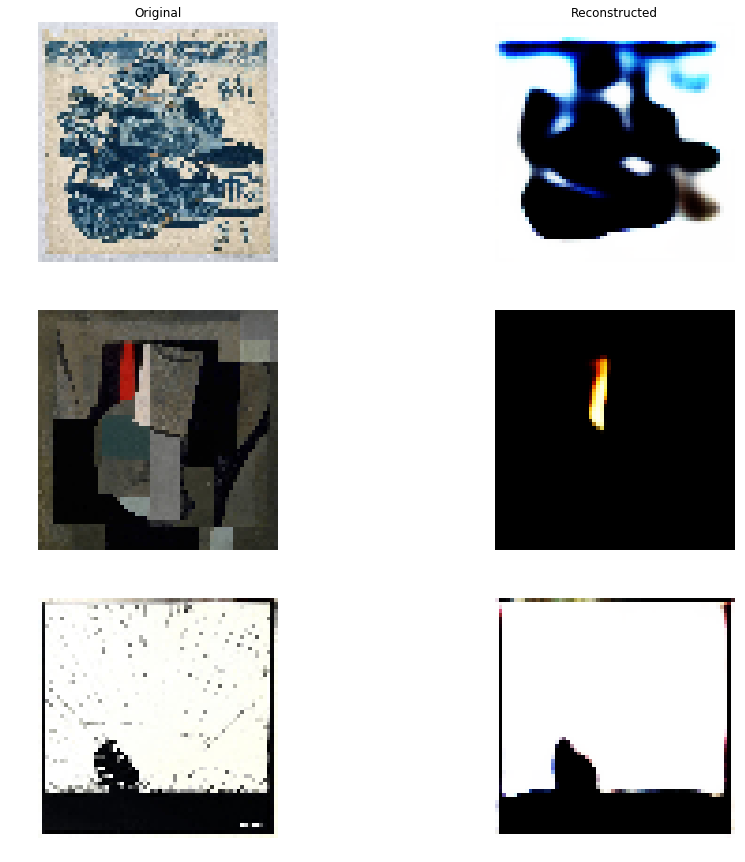

In [8]:
model_loc = MODEL_PATH / 'CVAE-128-64_model_best.pth.tar'
model = load_net(model_loc).to(device).eval()

display_results_auto(model, files_dict['val'], base_path=Path(PATH/'train_64'), num_samples=3)

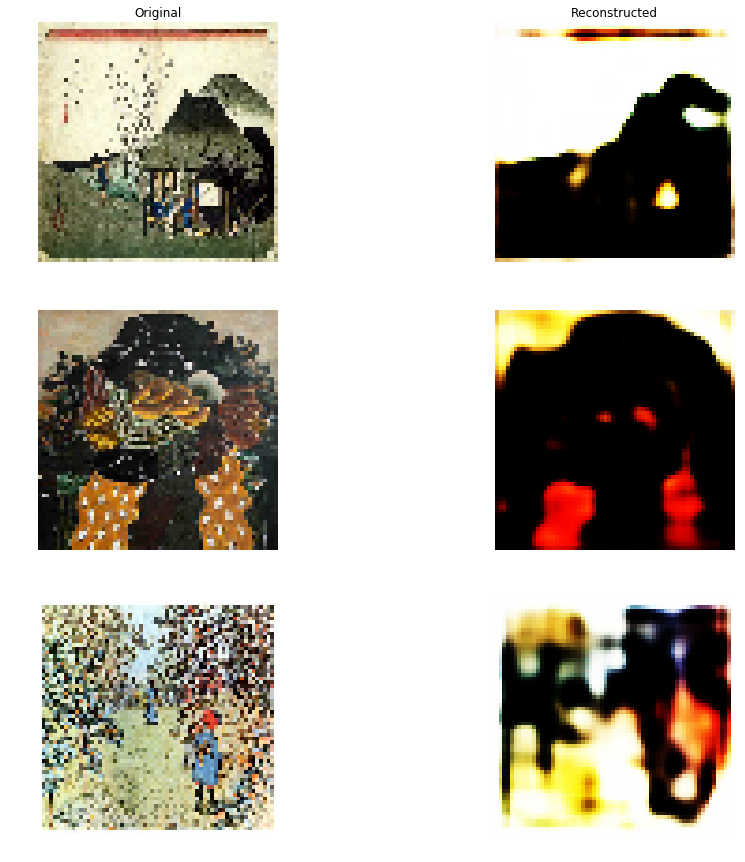

In [9]:
model_loc = MODEL_PATH / 'CVAE-256-64_model_best.pth.tar'
model = load_net(model_loc).to(device).eval()

display_results_auto(model, files_dict['val'], base_path=Path(PATH/'train_64'), num_samples=3)

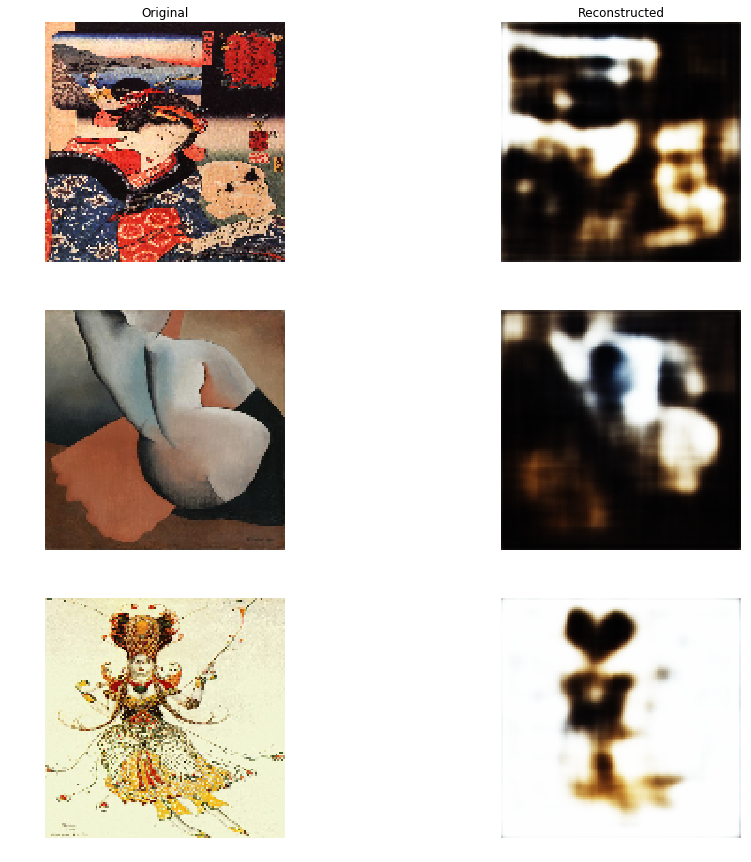

In [19]:
model_loc = MODEL_PATH / 'CVAE-256-128_model_best.pth.tar'
model = load_net(model_loc).to(device).eval()

display_results_auto(model, files_dict['val'], base_path=Path(PATH/'train_128'), num_samples=3, size=128)

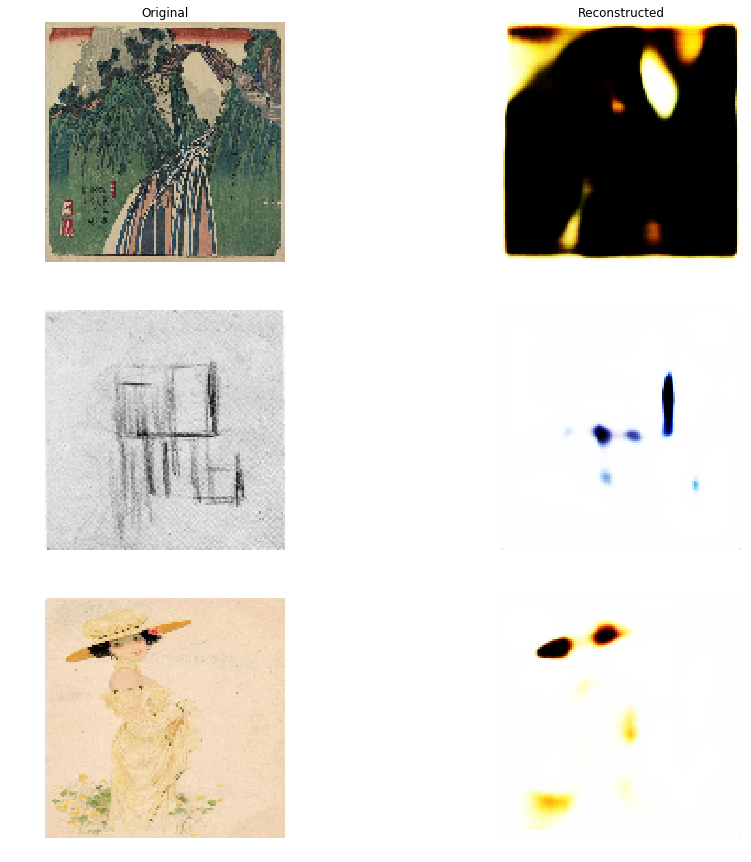

In [21]:
model_loc = MODEL_PATH / 'CVAE-128-128_model_best.pth.tar'
model = load_net(model_loc).to(device).eval()

display_results_auto(model, files_dict['val'], base_path=Path(PATH/'train_128'), num_samples=3, size=128)

# Test newer VAEs

In [2]:
files_df_loc = '/media/rene/data/adv_gen/MNIST/mnist_normal/files_df.pkl'

with open(files_df_loc, 'rb') as f:
    files_df = pickle.load(f)

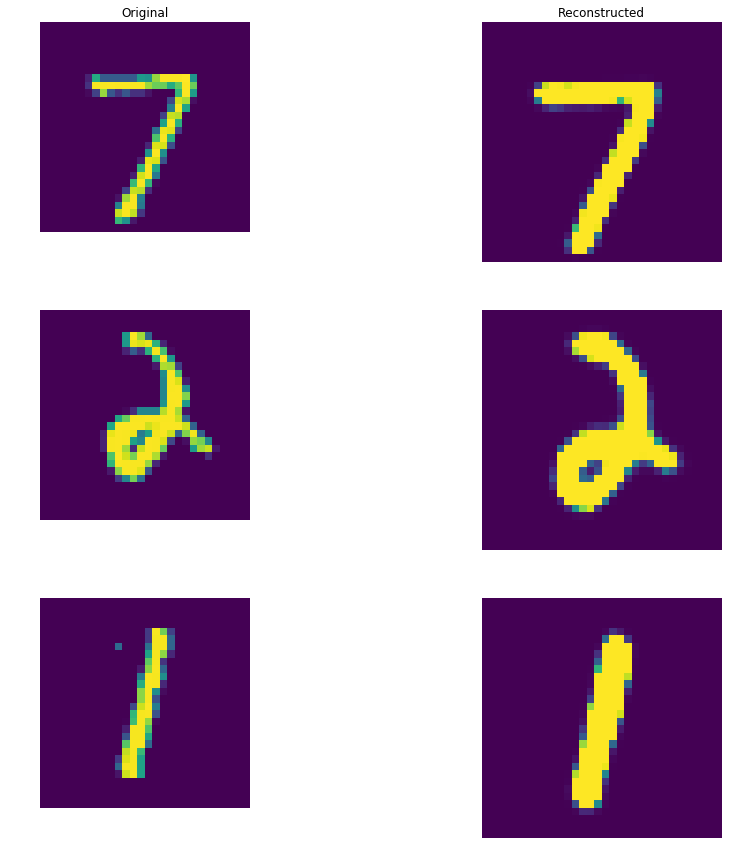

In [21]:
model = load_net(PATH /'test'/'CVAE-1_16_32_64-16-MNIST-10_model_best.pth.tar').to(device).eval()
display_results_auto(model, files_df['val'], num_samples=3)

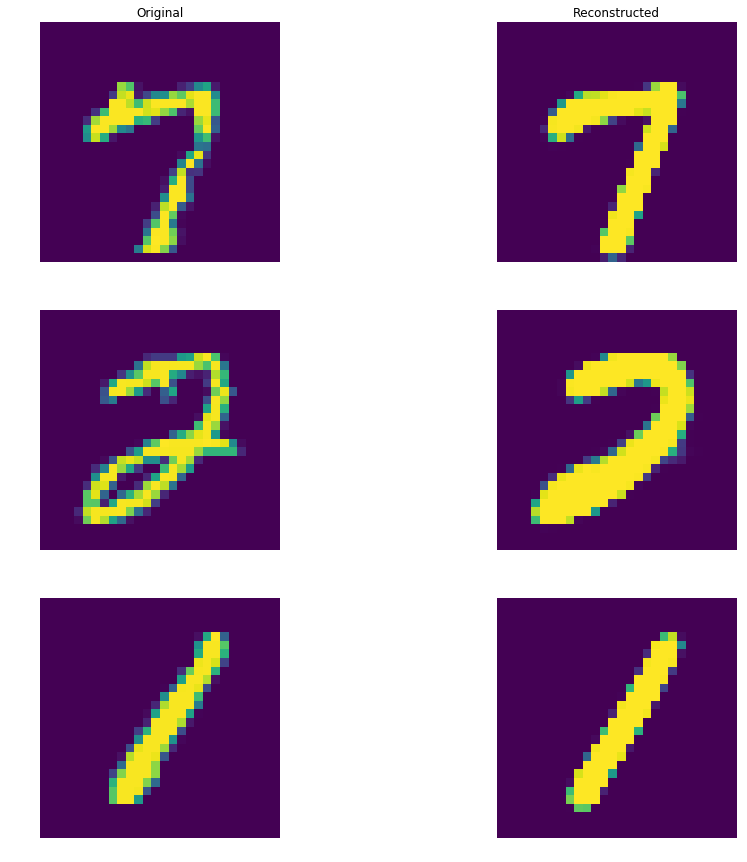

In [20]:
model = load_net(PATH /'CVAE'/'CVAE_ABS-8-MNIST_model_best.pth.tar').to(device).eval()
display_results_auto(model, files_df['val'], num_samples=3, data='mnist', size=28)